In [44]:
import numpy as np
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import * 


data shape: (5, 1)


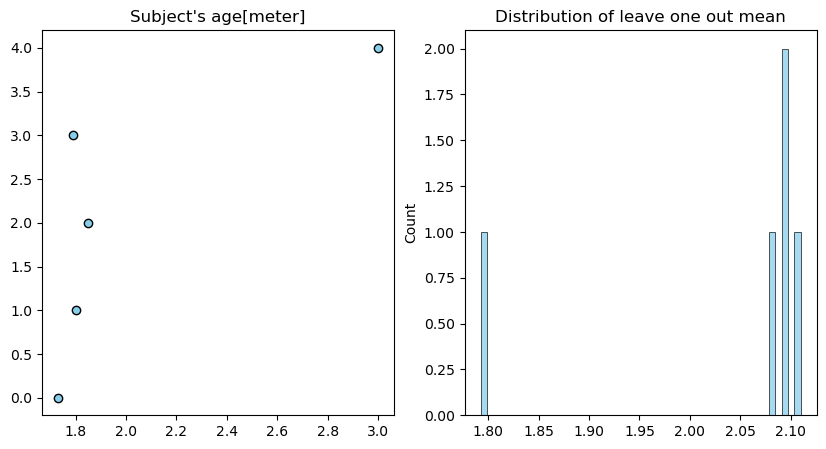

In [2]:
test_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0])
test_data = test_data.reshape(int(test_data.shape[0]), 1)
print(f"data shape: {test_data.shape}")

aprx_est = [np.mean(np.delete(test_data, loo)) for loo in range(test_data.shape[0])]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_data, [i for i in range(len(test_data))],color='skyblue',edgecolor='black')
plt.title("Subject's age[meter]")

plt.subplot(1, 2, 2)
sns.histplot(aprx_est, bins=50, color='skyblue',edgecolor='black')
plt.title("Distribution of leave one out mean")
plt.show()

# protector

In [3]:
def dp(participants):    
    all_noise = np.full(participants.shape[1], np.nan)

    for participant in range(participants.shape[1]):

        loo_estimate = participants[:, participant]
        true_mean = np.mean(loo_estimate)
        aprx_mean = loo_estimate
        sensitivity = np.max(np.abs(true_mean - aprx_mean)) 
        noise = np.random.laplace(loc=0.0, scale=sensitivity)
        all_noise[participant] = noise
    
    return all_noise

#np.random.seed(123)
#tsv = TSVHandler().load("group-merged-1.tsv")
#height = tsv[:,0]

aprx_est = np.array([np.mean(np.delete(test_data, loo)) for loo in range(test_data.shape[0])]).reshape(int(test_data.shape[0]), 1)


# attacker

In [4]:
noise = dp(aprx_est)
print(f"Noise: {noise}")
noisy_mean = aprx_est + 1 * noise 
print(f"LOO mean: {aprx_est.flatten()}")
print(f"Noisy mean: {noisy_mean.flatten()}")
print(f"Found subject index:", np.argmin(np.abs(noisy_mean.flatten())))


Noise: [-1.21185994]
LOO mean: [2.11   2.0925 2.08   2.095  1.7925]
Noisy mean: [0.89814006 0.88064006 0.86814006 0.88314006 0.58064006]
Found subject index: 4


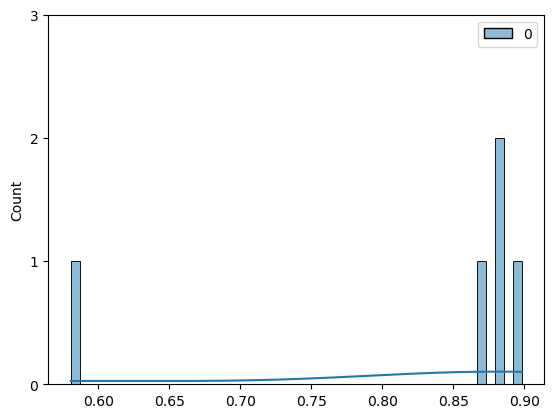

In [5]:
sns.histplot(noisy_mean, bins=50, color='skyblue', edgecolor='black', kde=True)
plt.yticks(np.arange(0, 4, step=1))
#plt.axvline(t_stat, color='green', linestyle='--', label=f't-stat = {t_stat:.2f}')
plt.show()

In [41]:
import statsmodels.stats.power as smp
mu_0 = 0.0
mu_1 = np.mean(noisy_mean) 
delta = mu_1 - mu_0
effect_size = delta/np.std(aprx_est)
print(f"delta: {delta}, effect size: {effect_size}")
smp.ttest_power(effect_size, nobs=100, alpha=0.05)

delta: 1.6987015363418805, effect size: 14.024255670070218


1.0

# T stats

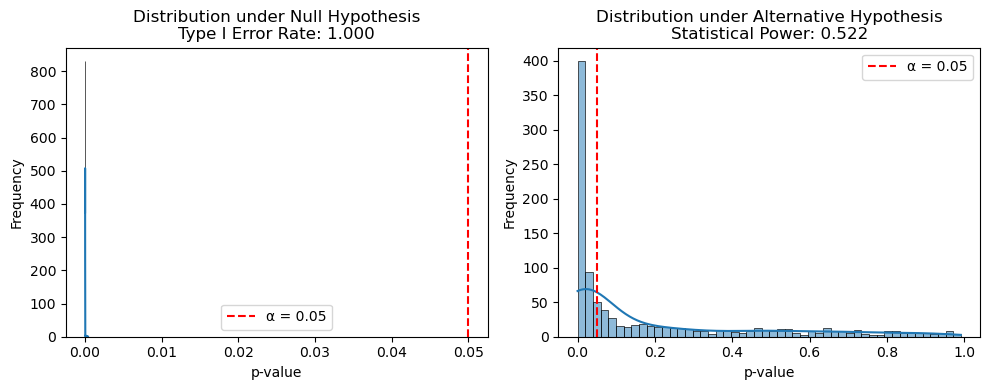

Effect size (Cohen's d): 16.79
Type I error rate: 1.000 (target: 0.05)
Statistical power: 0.522


In [43]:
mu_0 = 0.0   
mu_1 = np.mean(aprx_est)         
alpha = 0.05       
n_simulations = 1000 

p_values = list()
alt_p_values = list()


for _ in range(n_simulations):
    
    noise = dp(aprx_est)
    noisy_mean = aprx_est + 1 * noise 
    null_t, null_p = ttest_1samp(noisy_mean, mu_0)
    p_values.append(null_p)
    
    alt_t, alt_p = ttest_1samp(noisy_mean, mu_1)
    alt_p_values.append(alt_p)

null_p_values = np.array(p_values)
alt_p_values = np.array(alt_p_values)

type_I_error_rate = np.mean(null_p_values < alpha)
power = np.mean(alt_p_values < alpha)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(null_p_values, bins=50, color='skyblue', edgecolor='black', kde=True)
plt.axvline(alpha, color='red', linestyle='--', label=f'α = {alpha}')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Distribution under Null Hypothesis\n'f'Type I Error Rate: {type_I_error_rate:.3f}')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(alt_p_values, bins=50, color='lightgreen', edgecolor='black', kde=True)

plt.axvline(alpha, color='red', linestyle='--', label=f'α = {alpha}')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Distribution under Alternative Hypothesis\n'f'Statistical Power: {power:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

effect_size = (mu_1 - mu_0)/np.std(aprx_est)
print(f"Effect size (Cohen's d): {effect_size:.2f}")
print(f"Type I error rate: {type_I_error_rate:.3f} (target: {alpha})")
print(f"Statistical power: {power:.3f}")